# Oblivious Amplitude Amplification

Here, we implement the "oblivious" version of Grover's algorithm. We suppose $|a\rangle$ and $|b\rangle$ are two kets in a possibly large Hilbert space $\mathcal{H}$. We are given access to the unitaries $e^{i\phi}|a\rangle\langle a|$, $e^{i\phi}|b\rangle\langle b|$ for arbitrary $\phi$, as well as a fixed unitary $U$ for which all we know is that $\langle a|U|b\rangle \neq 0$. The aim of the algorithm is to construct, using these resources, a unitary $Q$ such that $|\langle a|Q|b\rangle| \approx 1$.

For our purposes, we consider a system of six qubits where $|a\rangle$ is a superposition of all strings with random nonzero weights, and $|b\rangle$ is the particular string $|111111\rangle$.

In [56]:
'''Some generic python and jupyter imports'''
import numpy as np
from numpy import pi,sqrt

'''Qiskit imports'''
from qiskit import(
    QuantumCircuit
    , execute
    , Aer
    , ClassicalRegister
    , QuantumRegister
)
backend_svec = Aer.get_backend('statevector_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')

'''Visualizations'''
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

### 1. State Preparation
First we begin by preparing our states. We are given that $|a\rangle$ is a superposition of all strings with random nonzero weights, and $|b\rangle$ is the particular string $|111111\rangle$.

In [57]:
# Define qubits
num_qubits = 6
qc = QuantumCircuit(num_qubits)

# Prep |a⟩: random superposition of all states
random_weights = np.random.rand(2**num_qubits)
random_weights /= np.linalg.norm(random_weights)  # normalize
statevector = random_weights  # normalized weights to |a⟩
qc.initialize(statevector, range(num_qubits))  # |a⟩

# Define |b⟩: |111111⟩ (already inherent in computational basis)
target_state_b = '1' * num_qubits


### 2. Define Reflection Operators
We now define our reflection operators using $e^{i\phi}|a\rangle\langle a|$ and $e^{i\phi}|b\rangle\langle b|$, using $\phi = \pi$.

In [58]:
# Define Bφ for |b⟩ = |111111⟩
qc_bphi = QuantumCircuit(num_qubits)
qc_bphi.mcx(list(range(num_qubits - 1)), num_qubits - 1)  # Controlled-Z
qc_bphi = qc_bphi.to_gate(label='Bφ')

# Aφ reflection: Use `statevector` as |a⟩
a_projector = np.outer(statevector, statevector.conj())
a_reflection_matrix = 2 * a_projector - np.eye(2**num_qubits)

qc_aphi = QuantumCircuit(num_qubits)
qc_aphi.unitary(a_reflection_matrix, range(num_qubits), label='Aφ')
qc_aphi = qc_aphi.to_gate(label='Aφ')

### 3. Create Random Unitary
We assume access to a fixed unitary which satisfies $\langle a|U|b\rangle \neq 0$.

In [59]:
# Construct Q
qc_q = QuantumCircuit(num_qubits)
qc_q.append(qc_bphi, range(num_qubits))  # Apply Bφ
qc_q.unitary(np.eye(2**num_qubits), range(num_qubits))  # U (Identity)
qc_q.append(qc_aphi, range(num_qubits))  # Apply Aφ
qc_q = qc_q.to_gate(label='Q')

### 4. Putting it Together
We use the unitaries and reflection operators to create a circuit for Q.

In [60]:
# Calculate a = ⟨a|b⟩
target_state_index = int(target_state_b, 2)  # Index of |b⟩ in the computational basis
a = statevector[target_state_index]  # Overlap ⟨a|b⟩
d = int(np.ceil(np.pi / (2 * np.arcsin(np.abs(a)))))
print(f"Number of Grover iterations: {d}")

# Apply Q d times
qc_amplification = QuantumCircuit(num_qubits)
for _ in range(d):
    qc_amplification.append(qc_q, range(num_qubits))

Number of Grover iterations: 214


### 5. Testing the Operator
To ensure this works, we apply this to b and check if a increases.

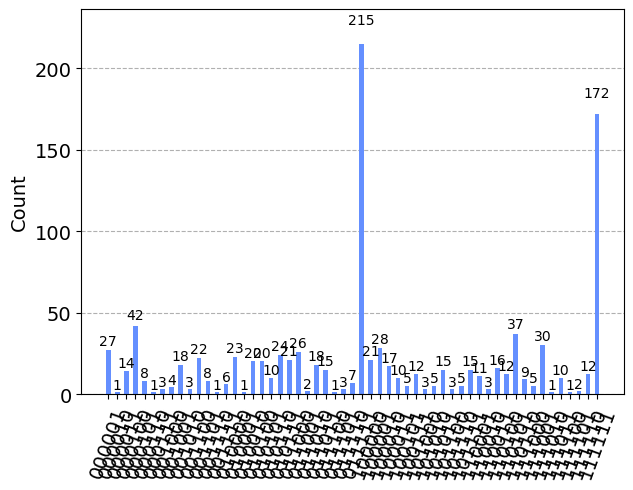

In [61]:
qc_final = QuantumCircuit(num_qubits)
qc_final.compose(qc, inplace=True)  # Initialize |a⟩
qc_final.compose(qc_amplification, inplace=True)  # Apply Q d times
qc_final.measure_all()

# Simulate
backend = Aer.get_backend('qasm_simulator')
result = execute(qc_final, backend, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)
